# Front Matter: CASA0013: Foundations of Spatial Data Science

## Title of Briefing

### Student ID: 21047001


# Reproducible Analysis

Please feel free to add as many code cells and markdown cells of comment/explanation as needed to make your code legible and clear. Your code should output any figures needed to disk.

## 1. Import packages 


In [1]:
import os
import json
import numpy as np
import pandas as pd
import geopandas as gpd

## 2. Load London MSOAs Data


### 2.1. Load MSOA data shapefile

<AxesSubplot:>

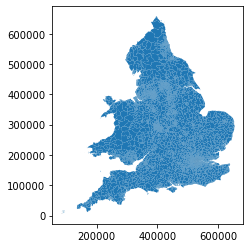

In [2]:
msoas = gpd.read_file('https://github.com/joeylizh/i2p/blob/main/assessments/coursework3/cw_data/Middle_Layer_Super_Output_Areas__December_2011__EW_BGC_V2-shp.zip?raw=true')
# MSOA geopackage source link: https://geoportal.statistics.gov.uk/datasets/middle-layer-super-output-areas-december-2011-boundaries-full-extent-bfe-ew-v3/

msoas.plot()

In [3]:
msoas.sample(3)

,OBJECTID,MSOA11CD,MSOA11NM,MSOA11NMW,BNG_E,BNG_N,LONG,LAT,Shape__Are,Shape__Len,geometry
1482,1483,E02001521,Barnsley 013,Barnsley 013,433979,406046,-1.48863,53.54997,3.421273e+06,12383.259035,"POLYGON ((435059.000 406957.000, 435070.826 40..."
1814,1815,E02001863,Birmingham 037,Birmingham 037,408195,289817,-1.88068,52.50620,2.268744e+06,8101.140694,"POLYGON ((408609.000 290869.000, 408820.000 29..."
249,250,E02000256,Ealing 019,Ealing 019,517071,181097,-0.31415,51.51667,1.091838e+06,4807.753171,"POLYGON ((517451.952 181789.847, 517555.916 18..."


In [4]:
for gpkg in [msoas]:
    print(gpkg.crs)

epsg:27700


### 2.2. Set London Brough Boundaries

In [53]:
boros = gpd.read_file('https://github.com/joeylizh/i2p/blob/main/assessments/coursework3/cw_data/Boroughs.gpkg?raw=true')
# Borough geopackage source link: 

# boros.plot()
boros.shape

/opt/conda/envs/sds2021/lib/python3.9/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


(33, 6)

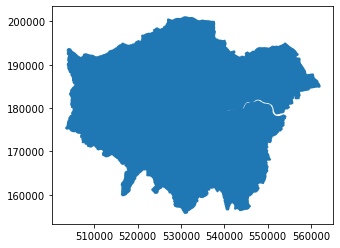

In [6]:
ldn = gpd.GeoDataFrame(gpd.GeoSeries(data=boros.unary_union, crs='epsg:27700')).rename(columns={0:'original'})

# The boundary is buffered by 250m in order to ensure all MSOAs _within_ London can be ontained 

ldn['geometry'] = ldn.original.buffer(250)
ldn = ldn.set_geometry('geometry')
ldn.plot();

### 2.3. Set London MSOAs

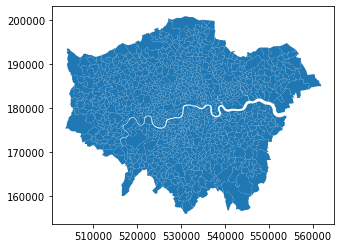

In [7]:
ldn_msoas = gpd.sjoin(msoas, ldn, op='within')
ldn_msoas.plot();

In [8]:
del(msoas)

## 3. Load Cultural Infrastructure Data

### 3.1. Load cultural infrastructure (culin) csv data

In [47]:
url='https://raw.githubusercontent.com/joeylizh/i2p/main/assessments/coursework3/cw_data/cultural_infrastructure_all_sites.csv'
# Cultural infrastructure source link: 
# https://data.london.gov.uk/dataset/cultural-infrastructure-map

df_culin = pd.read_csv(url, low_memory=False)
df_culin.shape

(10003, 29)

In [48]:
# clean the data

df_culin.drop(df_culin[((df_airbnb.latitude.isna())|(df_culin.longitude.isna()))].index, axis=0, inplace=True)
df_culin.drop(df_culin[((df_airbnb.latitude < 40)|(df_culin.longitude > 1))].index, axis=0, inplace=True)
print(df_culin.shape)

(10003, 29)


/tmp/ipykernel_833/1420575108.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_culin.drop(df_culin[((df_airbnb.latitude.isna())|(df_culin.longitude.isna()))].index, axis=0, inplace=True)
/tmp/ipykernel_833/1420575108.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_culin.drop(df_culin[((df_airbnb.latitude < 40)|(df_culin.longitude > 1))].index, axis=0, inplace=True)


### 3.2. Convert the dataframe into a GeoDataFrame(gdf)

In [50]:
gdf_culin = gpd.GeoDataFrame(df_culin, geometry=gpd.points_from_xy(df_culin.longitude, df_culin.latitude,
                                                       crs='epsg:4326'))
gdf_culin = gdf_culin.to_crs('epsg:27700')

### 3.7. Check results

KeyError: 'NAME'

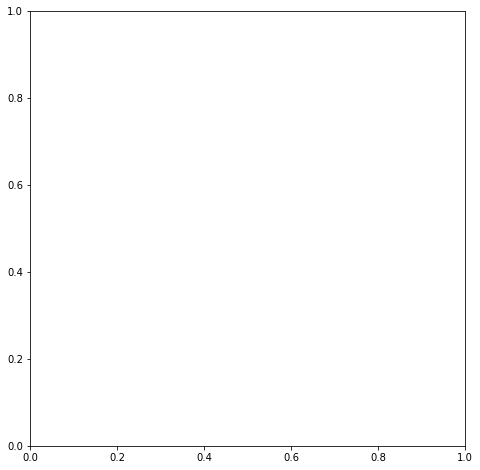

In [52]:
ax = gdf_culin.plot(column='NAME', markersize=0.5, alpha=0.5, figsize=(10,8))
boros.plot(ax=ax, edgecolor='r', facecolor='None', alpha=0.5);

## 4. Load Inside Airbnb Data


### 4.1. Load Inside Airbnb listings data

In [23]:
url='https://raw.githubusercontent.com/joeylizh/i2p/main/assessments/coursework3/cw_data/2021-10-10-listings.csv'

cols = ['id','name','price','latitude','longitude','room_type']

df_airbnb = pd.read_csv(url, usecols=cols, low_memory=False)
df_airbnb.shape
# df_airbnb.columns
# df_airbnb.sample(3)

(67903, 6)

In [28]:
# clean the data

df_airbnb['price'] = df_airbnb.price.astype(float)
df_airbnb.drop(df_airbnb[((df_airbnb.latitude.isna())|(df_airbnb.longitude.isna()))].index, axis=0, inplace=True)
df_airbnb.drop(df_airbnb[((df_airbnb.latitude < 40)|(df_airbnb.longitude > 1))].index, axis=0, inplace=True)
print(df_airbnb.shape)

(67903, 6)


### 4.2. Convert the dataframe into a GeoDataFrame(gdf)

In [31]:
gdf_airbnb = gpd.GeoDataFrame(df_airbnb, geometry=gpd.points_from_xy(df_airbnb.longitude, df_airbnb.latitude,
                                                       crs='epsg:4326'))
gdf_airbnb = gdf_airbnb.to_crs('epsg:27700')

### 4.3.  Add Local Authority Names to Data
Associate Local Authority (LA) names to the listings using a spatial join:

In [33]:
gdf_la = gpd.sjoin(gdf_airbnb, boros, op='within', how='left')
print(gdf_la.columns.values)

['id' 'name' 'latitude' 'longitude' 'room_type' 'price' 'geometry'
 'index_right' 'NAME' 'GSS_CODE' 'HECTARES' 'NONLD_AREA' 'ONS_INNER']


In [34]:
print(gdf_la.shape)
gdf_la.sample(3, random_state=42)[['id','name','NAME']]

(67903, 13)


,id,name,NAME
53662,42409608,Cosy two bedroom home full of character,Merton
49155,39318693,Frills-free yet Clean and Comfortable Bedroom,Tower Hamlets
36922,29555250,Unmissable Luxurious Mews House in Central London,Westminster


### 4.4. Tidy up

In [36]:
gdf_la.drop(columns=['index_right','HECTARES','NONLD_AREA','ONS_INNER'], inplace=True)
gdf_la.NAME.unique()

array(['Islington', 'Kensington and Chelsea', 'Westminster',
       'Hammersmith and Fulham', 'Wandsworth', 'Barnet', 'Hounslow',
       'Richmond upon Thames', 'Haringey', 'Croydon', 'Southwark',
       'Waltham Forest', 'Brent', 'Camden', 'Newham', 'Tower Hamlets',
       'Lambeth', 'Hackney', 'Merton', 'Lewisham', 'Bromley', 'Havering',
       'Greenwich', 'Ealing', 'Enfield', 'City of London',
       'Barking and Dagenham', 'Hillingdon', 'Harrow', 'Redbridge',
       'Kingston upon Thames', 'Bexley', 'Sutton', nan], dtype=object)

### 4.5. Map problematic listings

<AxesSubplot:>

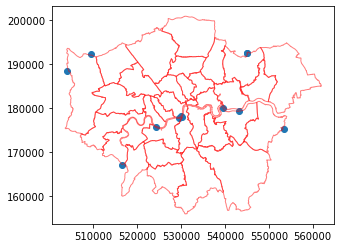

In [37]:
ax = gdf_la[gdf_la.NAME.isna()].plot()
boros.plot(ax=ax, edgecolor='r', facecolor='None', alpha=0.5)

### 4.6. Drop problematic listings

In [39]:
gdf_la.drop(index=gdf_airbnb[gdf_la.NAME.isna()].index, axis=1, inplace=True)
print(gdf_la.shape)

(67891, 9)


### 4.7. Check results

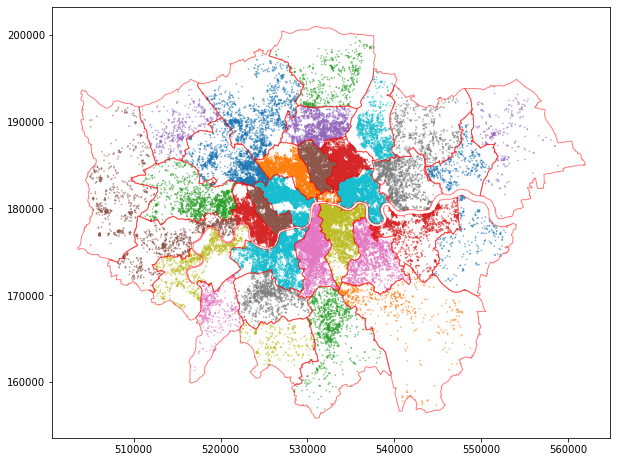

In [40]:
ax = gdf_la.plot(column='NAME', markersize=0.5, alpha=0.5, figsize=(10,8))
boros.plot(ax=ax, edgecolor='r', facecolor='None', alpha=0.5);

## 5. Exploring an LA